In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

In [8]:
# 데이터 불러오기
sales = pd.read_csv('./data/sales_train.csv')
items = pd.read_csv('./data/items.csv')
item_categories = pd.read_csv('./data/item_categories.csv')
shops = pd.read_csv('./data/shops.csv')
test = pd.read_csv('./data/test.csv')

# 1. 전처리

## 2. sales 데이터

In [5]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [9]:
time_cut = time.time()
sales.date = sales.date.astype('datetime64')
sales
time.time() - time_cut

0.2941417694091797

In [7]:
time_cut = time.time()
sales.date = sales.date.apply(lambda x : datetime.strptime(x,'%d.%m.%Y'))
sales.date
time.time() - time_cut

19.861774682998657

In [6]:
sales.shape # (2935849, 6)

(2935849, 6)

In [7]:
sales.corr() # 상관계수

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


In [8]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


- 중복데이터 처리

In [9]:
sales = sales.drop_duplicates()
sales.shape  # (2935849, 6) -> (2935843, 6)

(2935843, 6)

- 특정 행 제거

In [10]:
# item_price 가 0 이하인 경우
(sales.item_price <= 0).sum()

1

In [11]:
sales = sales[sales.item_price > 0]

In [12]:
# 팔린 상품의 개수가 (-) 인 경우 -> 행 삭제?, 이전 주문과 함께 삭제
(sales['item_cnt_day'] < 0).sum()

7356

In [13]:
sales = sales[sales.item_cnt_day >= 0]

- 결측치 처리

In [14]:
# 결측치 없음
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

- 이상치 처리

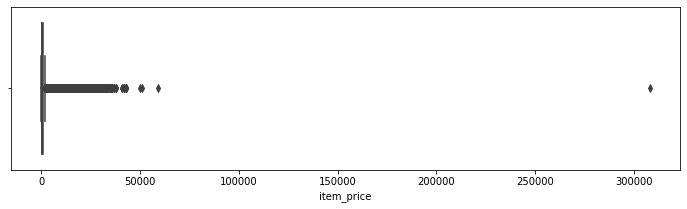

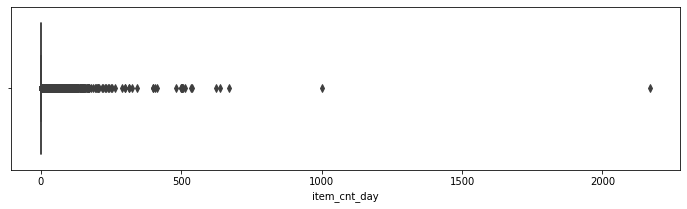

In [15]:
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales)
plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)
plt.show()

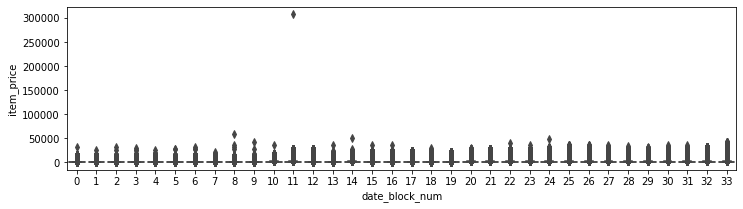

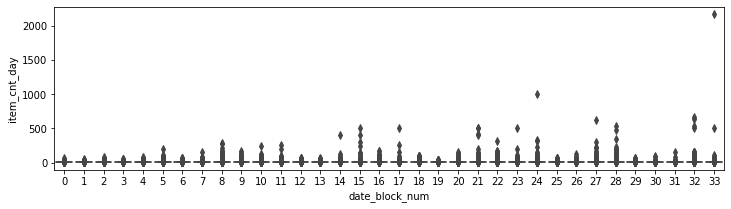

In [16]:
plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_price', data = sales)
plt.figure(figsize=(12,3))
sns.boxplot(x = 'date_block_num', y = 'item_cnt_day', data = sales)
plt.show()

In [17]:
# 뚜렷한 이상치를 우선 제거 -> 분석하면서 확인하기
sales = sales[sales.item_cnt_day < 500]
sales = sales[sales.item_price < 50000]

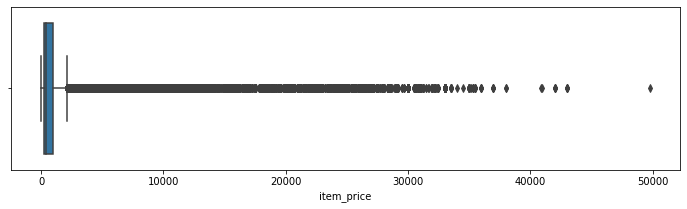

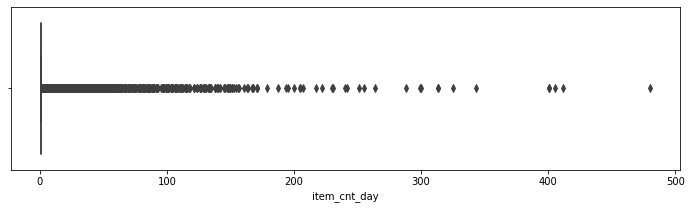

In [18]:
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales);
plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)

plt.show()

## 2. items data

In [19]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [20]:
items.drop(['item_name'], axis=1, inplace=True)

In [21]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


### 3. item_categoris data

In [22]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [23]:
type_encoder = LabelEncoder()
item_categories['split_name'] = item_categories['item_category_name'].str.split(' - ')
item_categories['type'] = item_categories['split_name'].map(lambda x: x[0].strip())
item_categories['type_id'] = type_encoder.fit_transform(item_categories['type'])

In [24]:
item_categories.head()

,item_category_name,item_category_id,split_name,type,type_id
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1
2,Аксессуары - PS3,2,"[Аксессуары, PS3]",Аксессуары,1
3,Аксессуары - PS4,3,"[Аксессуары, PS4]",Аксессуары,1
4,Аксессуары - PSP,4,"[Аксессуары, PSP]",Аксессуары,1


In [25]:
item_categories = item_categories[['item_category_id','type_id']]

In [26]:
item_categories.head()

,item_category_id,type_id
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


### 4. shops data

In [27]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [28]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [29]:
# 공백(' ')을 기준으로 분리
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [30]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [31]:
city_encoder = LabelEncoder()
shops['city_id'] = city_encoder.fit_transform(shops['city'])
shops = shops[['shop_id', 'city_id']]
shops.head()

,shop_id,city_id
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


In [32]:
shops.city_id.value_counts()

14    13
25     3
5      3
19     3
0      2
12     2
30     2
26     2
21     2
20     2
17     2
16     2
9      2
7      2
11     1
23     1
2      1
29     1
28     1
27     1
3      1
4      1
24     1
22     1
13     1
6      1
8      1
18     1
1      1
15     1
10     1
31     1
Name: city_id, dtype: int64

### 5. test data

In [33]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [34]:
test.shape

(214200, 3)

In [35]:
# test 데이터에서 shop_id는 42개
len(test.shop_id.unique())

42

In [36]:
# test 데이터에는 있지만 sales 데이터에는 없는 item_id가 총 363개 있다.
# 363개의 item_id에 대한 판매량은 0으로 예측
len(set(test.item_id) - set(sales.item_id))

363

In [11]:
### 환불 적용 모듈
train_F = sales.copy()
k = train_F[train_F.item_cnt_day < 0]
timefunc = time.time()
for i in range(len(k)):
    try:
        a = (train_F[(train_F.item_id == k.iloc[i,3]) & (train_F.shop_id == k.iloc[i,2])])
        if a.date.min() < k.iloc[i,0]:
            h = a[(a.date==a.date[a.date < k.iloc[i,0]].max())].index[0]
            if train_F.loc[h,'item_cnt_day'] > abs(k.iloc[i,5]):
                train_F.loc[h,'item_cnt_day'] += k.iloc[i,5]
        else:
            pass
    except:
        pass
print(time.time() - timefunc)

95.32195925712585


In [10]:
### 환불 적용 모듈
train_F = sales.copy()
k = train_F[train_F.item_cnt_day < 0]
qwe = 0
minimum = 0
timefunc = time.time()
for i in range(len(k)):
    try:
        if k.iloc[i,5] < minimum:
            minimum = k.iloc[i,5]
        a = (train_F[np.array(train_F.item_id == k.iloc[i,3]) & np.array(train_F.shop_id == k.iloc[i,2])])
        if a.date.min() < k.iloc[i,0]:
            h = a[a.date==a.date[a.date < k.iloc[i,0]].max()].index[0]
            qwe += 1
            train_F.loc[h,'item_cnt_day'] += k.iloc[i,5]
#            if qwe == 5:
#                break
        else:
            pass
    except:
        pass
train_F.drop(k.index,axis = 0,inplace = True)
print(len(k))
print('필요 없는 값:',(len(k) - qwe))
print('적용한 값의 수::',qwe)
print(minimum)
print(time.time() - timefunc)

7356
필요 없는 값: 422
적용한 값의 수:: 6934
-22.0
219.95520496368408


### 데이터 merge

In [38]:
#sales['item_category_id']=items['item_category_id']
#sales.head()

### 추가 컬럼 만들기

In [39]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [40]:
# 총 수익
sales['revenue'] = sales['item_price'] * sales['item_cnt_day']
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00
5,2013-01-10,0,25,2564,349.00,1.0,349.00


In [41]:
ts = time.time() # 코드 시작 시간
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id'] # 월별, 상점별, 아이템별
for i in range(34):
    sales_df = sales[sales.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], sales_df.shop_id.unique(), sales_df.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
time.time()-ts # 코드 실행 시간

# itertools.product : 중복 순열
# 월별, 상점별, 아이템별로 모든 가능한 조합을 나타낸다.
# vstack : 이 조합들을 월 순서대로 행 아래에 더해준다.

14.108488082885742

In [42]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [43]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left') # 'city_id' 추가 됨
matrix= pd.merge(matrix, items, on=['item_id'], how='left')
matrix= pd.merge(matrix, item_categories, on=['item_category_id'], how='left') # 'item_category_id', 'type_id' 추가 됨

# 결과적으로 위의 matrix1 데이터에 3개 컬럼 추가

In [44]:
matrix.head()

,date_block_num,shop_id,item_id,city_id,item_category_id,type_id
0,0,0,19,0,40,11
1,0,0,27,0,19,5
2,0,0,28,0,30,8
3,0,0,29,0,23,5
4,0,0,32,0,40,11


In [55]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00
5,2013-01-10,0,25,2564,349.00,1.0,349.00


In [59]:
# 월별 매출액
# 월별, 상점별, 아이템별을 그룹화 하고, 일별 판매 개수('item_cnt_day')를 더해준다.
group = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
print(group.head())
group1 = sales.groupby(['date_block_num']).agg({'revenue' : ['sum']})
print(group1.head())

                               item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0
                     revenue
                         sum
date_block_num              
0               9.239894e+07
1               9.096449e+07
2               1.052654e+08
3               6.945713e+07
4               6.525317e+07


In [46]:
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [12]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-09-10,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [16]:
salem=sales.copy()

In [22]:
salem.sort_values('date_block_num',inplace = True)

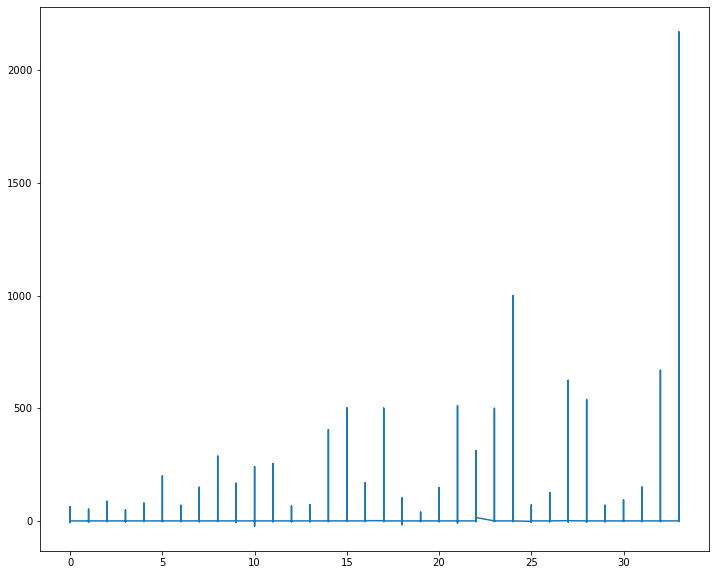

In [23]:
plt.figure(figsize = (12,10))
plt.plot(salem.date_block_num,salem.item_cnt_day)

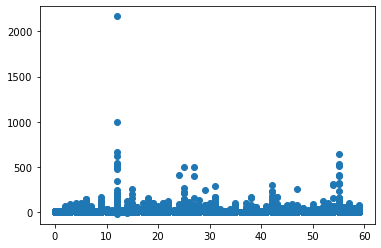

In [24]:
plt.scatter(salem.shop_id,salem.item_cnt_day)

In [47]:
# matrix 에 gorup merge 하여 컬럼을 붙임('item_cnt_month')
matrix = pd.merge(matrix, group, how='left')
matrix.head()
# NaN 값은 판매 개수가 없다고 판단 -> 0으로 처리??

,date_block_num,shop_id,item_id,city_id,item_category_id,type_id,item_cnt_month
0,0,0,19,0,40,11,NaN
1,0,0,27,0,19,5,NaN
2,0,0,28,0,30,8,NaN
3,0,0,29,0,23,5,NaN
4,0,0,32,0,40,11,6.0


In [48]:
# 결측값을 어떻게 처리 할 지 생각해보기!!!
# 일단 0으로 처리
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).astype(np.float16))
matrix.head()

,date_block_num,shop_id,item_id,city_id,item_category_id,type_id,item_cnt_month
0,0,0,19,0,40,11,0.0
1,0,0,27,0,19,5,0.0
2,0,0,28,0,30,8,0.0
3,0,0,29,0,23,5,0.0
4,0,0,32,0,40,11,6.0


In [49]:
matrix['decjan'] = np.where(matrix['date_block_num'].isin([11,12,23,24]), 1,0)
matrix.head()

,date_block_num,shop_id,item_id,city_id,item_category_id,type_id,item_cnt_month,decjan
0,0,0,19,0,40,11,0.0,0
1,0,0,27,0,19,5,0.0,0
2,0,0,28,0,30,8,0.0,0
3,0,0,29,0,23,5,0.0,0
4,0,0,32,0,40,11,6.0,0


In [50]:
print(len(matrix.loc[matrix['date_block_num'] == 11,:]))
print(len(matrix.loc[matrix['date_block_num'] == 12,:]))
print(len(matrix.loc[matrix['date_block_num'] == 23,:]))
print(len(matrix.loc[matrix['date_block_num'] == 24,:]))

389712
347116
330000
306800


In [51]:
389712+347116+330000+306800

1373628

In [ ]:
(matrix['decjan'] == 1).sum()

In [ ]:
## matrix에 월별 shop별 평균 판매 수량(shop_cnt_month) 
group2 = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['sum']})
group2.columns = ['shop_cnt_month']
group2.reset_index(inplace=True)

In [ ]:
matrix = pd.merge(matrix, group2, on=['date_block_num', 'shop_id'], how='left')
matrix.head()

In [ ]:
matrix1 = matrix.copy()

In [ ]:
matrix1.head()

In [ ]:
# 마지막 판매가 있고 나서부터 지난 개월 수 -> 추세 파악을 위해 먼저 이 코드 실행
# shop-item 별

cache = {}
matrix1['item_shop_last_sale'] = -1
matrix1['item_shop_last_sale'] = matrix1['item_shop_last_sale'].astype(np.int8)

for index, row in matrix1.iterrows():
    key = str(row.item_id) + ' ' + str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix1.at[index, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num
# 20분 걸림

In [ ]:
# item별
cache = {}
matrix1['item_last_sale'] = -1
matrix1['item_last_sale'] = matrix1['item_last_sale'].astype(np.int8)

for index, row in matrix1.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix1.at[index, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

# 15분 걸림

In [ ]:
#첫번째 판매 후 지난 개월 수 (shop-item pair, item pair 별)

matrix1.groupby(['item_id','shop_id'])['date_block_num']
matrix1['date_block_num'] - matrix1.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')

In [ ]:
matrix1['item_shop_first_sale'] = matrix1['date_block_num'] - matrix1.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
matrix1['item_first_sale'] = matrix1['date_block_num'] - matrix1.groupby('item_id')['date_block_num'].transform('min')
matrix1.head()

# 2. EDA

1. 월별 거래수

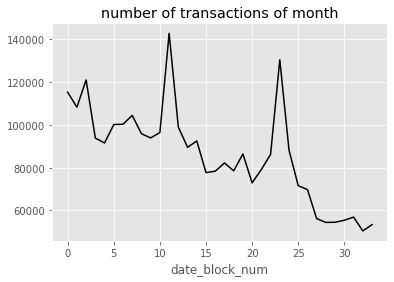

In [ ]:
#월별 거래수
sales.groupby('date_block_num').count()
sales.groupby('date_block_num')['date'].count()

transactions = sales.groupby('date_block_num')['date'].count()
transactions

plt.style.use('ggplot')
transactions.plot(title = 'number of transactions of month', color = 'black')
plt.show()

#전체적으로 월별 거래수가 꾸준히 하락함
#엄청 높게 치솟는 두 개 점은 연말(13년 12월, 14년 12월)임

2. 월별 거래된 shops 수, 월별 거래된 items 수

In [ ]:
#각 월 블록에서 매출 데이터에 거래가 있는 고유 상점 및 품목 수
shop_count = sales.groupby('date_block_num')['shop_id'].nunique()
item_count = sales.groupby('date_block_num')['item_id'].nunique()

sales.groupby('date_block_num').nunique()
#sales.groupby('date_block_num')['shop_id'].nunique() #월별 고유 상점수
#sales.groupby('date_block_num')['item_id'].nunique()  #d월별 고유 아이템수

sales['item_id'].nunique() #item 21802개
items['item_id'].nunique() #item 22170개
#sales['shop_id'].nunique() #shop 60개
shops['shop_id'].nunique() #shop 60개

#sales에 있는 item_id랑 items에 있는 item_id의 수가 다름

60

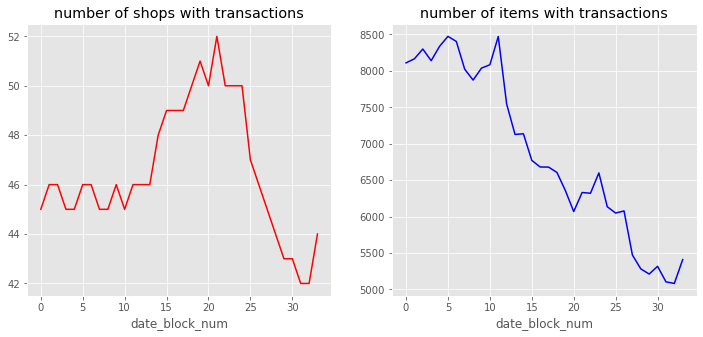

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
shop_count.plot(ax = ax[0], color = 'red')
item_count.plot(ax = ax[1], color = 'blue')
ax[0].set_title('number of shops with transactions') #거래가 있는 상점수
ax[1].set_title('number of items with transactions') #거래된 아이템수
plt.show()

In [ ]:
#연말을 제외하고는 월별 거래수와 월별 거래된 아이템수 모두 하락세
#거래처들의 수는 2년차부터는 느는 듯 했으나 2말부터 훅훅 떨어짐

#그리고 거래처수가 60개로 나오는데 차트를 보면 매달 모든 가게에서 거래되는 게 아니고
#물건도 많이 못미친다

3. 상점 별 하루 item 판매 개수

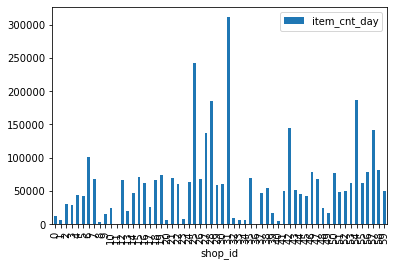

In [ ]:
shop_ns = sales[['shop_id','item_cnt_day']]
shop_ns.set_index(['shop_id'])
shop_ns = shop_ns.groupby(by=['shop_id']).sum()
shop_ns.plot(kind = 'bar')
plt.show()

4. 가격 별 item 하루 판매 개수

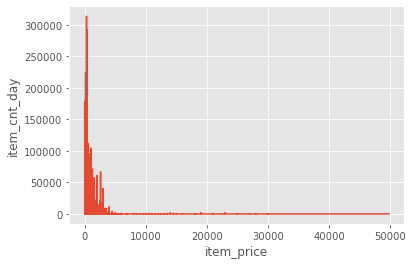

In [ ]:
price_ns = sales[['item_price','item_cnt_day']]
price_ns = price_ns.groupby(by=['item_price']).sum()
plt.plot(price_ns.index, price_ns.values)
plt.xlabel('item_price')
plt.ylabel('item_cnt_day')
plt.show()

5. 월 별 총 판매금액

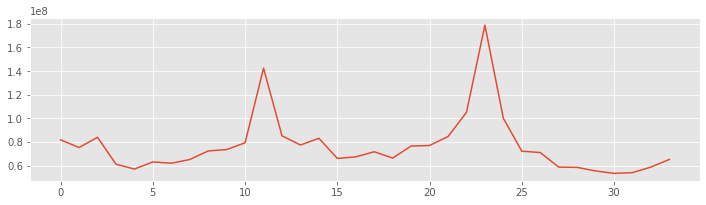

In [ ]:
# 월 별 총 판매금액
time_ns = sales[['item_price','date_block_num']]
time_ns = time_ns.groupby(by=['date_block_num']).sum()
plt.figure(figsize=(12,3))
plt.plot(time_ns.index, time_ns.values)
plt.show()

6. 월별 총 판매개수

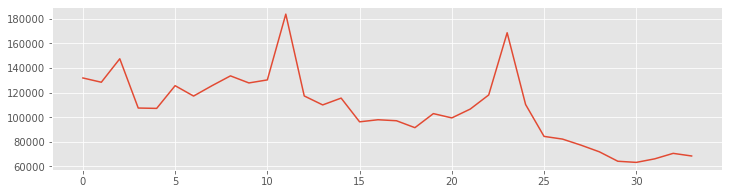

In [ ]:
# 월 별 총 판매개수
group1 = sales.groupby(by=['date_block_num']).sum()
group1 = group1.reset_index()
plt.figure(figsize=(12,3))
plt.plot(group1.date_block_num,  group1.item_cnt_day)
plt.show()

7. 품목별 판매량

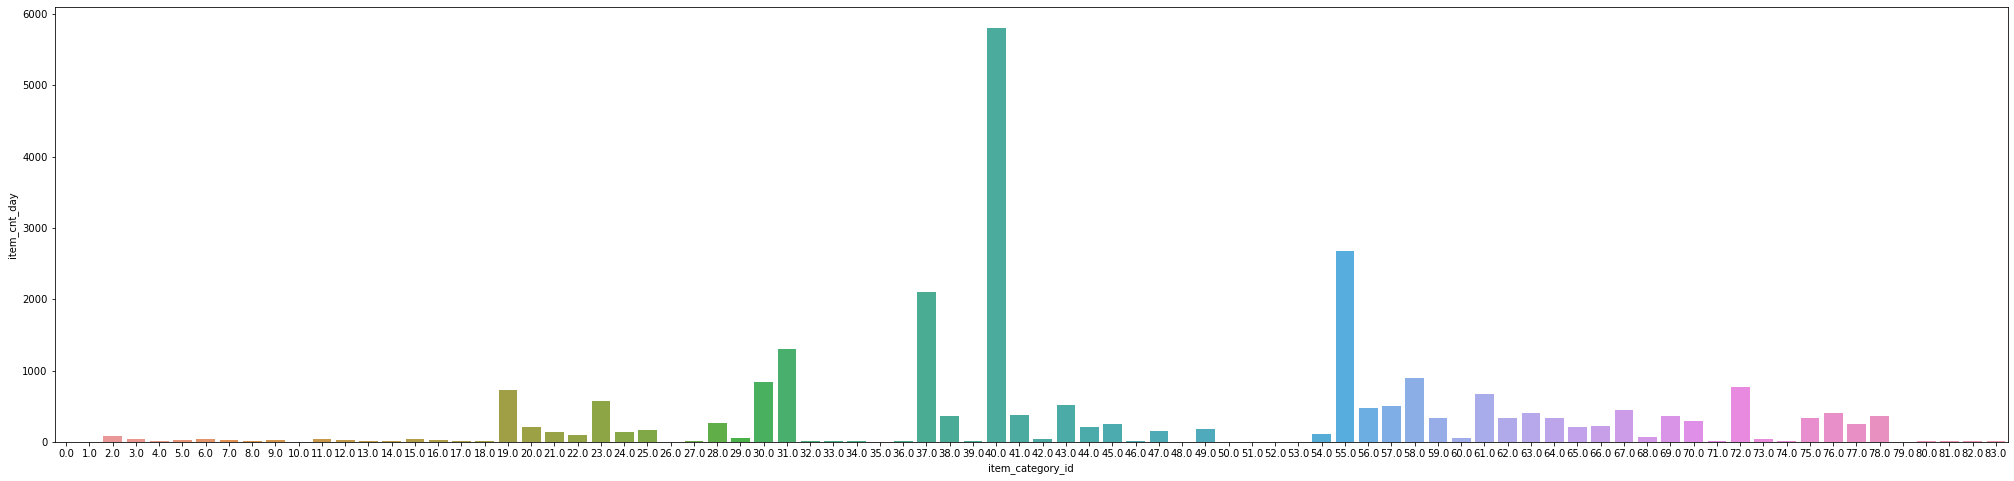

In [ ]:
# 품목별 판매량 
Category_sum=sales.groupby(['item_category_id'], as_index=False)['item_cnt_day'].sum()
fig, axes = plt.subplots(1,1,figsize = (35,8))
sns.barplot(x="item_category_id",y="item_cnt_day", data=Category_sum)
plt.show()

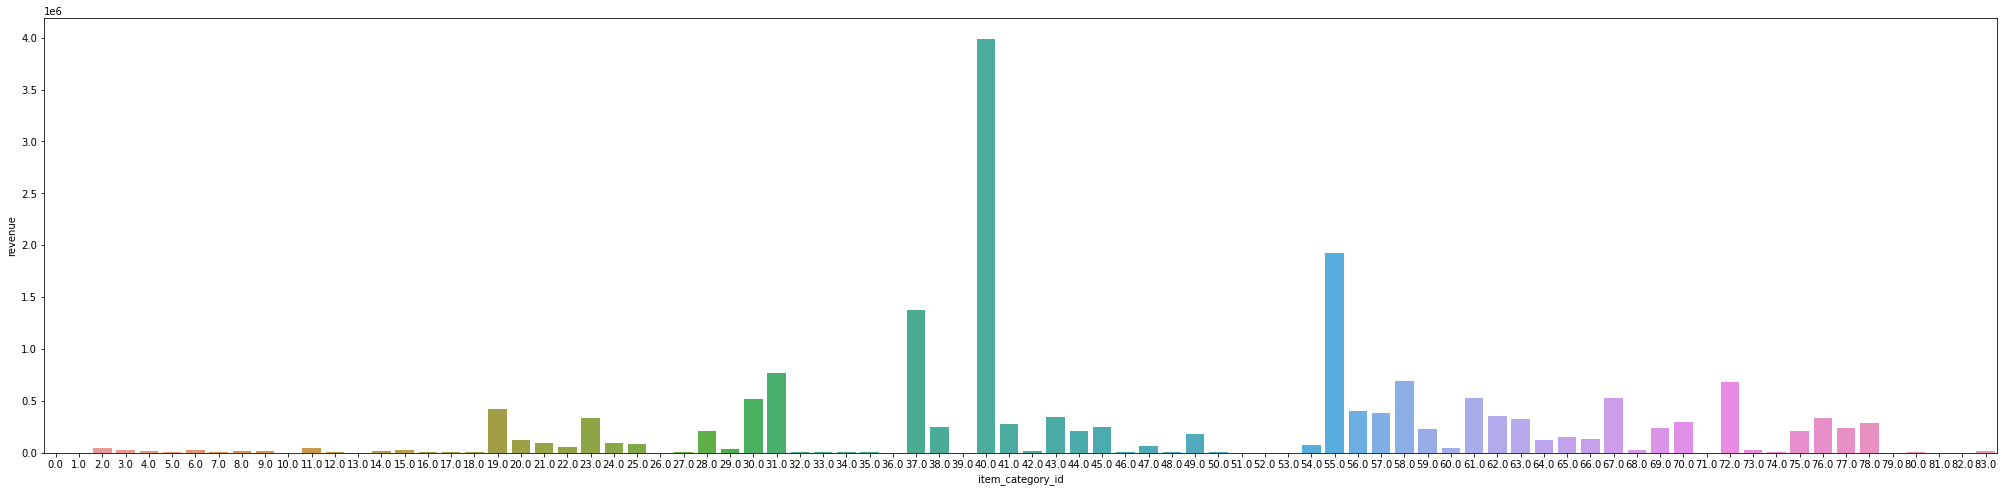

In [ ]:
# 카테고리별 판매금액
Category_sum=sales.groupby(['item_category_id'], as_index=False)['revenue'].sum()
fig, axes = plt.subplots(1,1,figsize = (35,8))
sns.barplot(x="item_category_id",y="revenue", data=Category_sum)
plt.show()

In [ ]:
#연도별 판매량  -> Year, Month 컬럼 만든 후 확인 가능합니다(이재호)
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales_data['Year'],y=sales_data['item_cnt_day'])
plt.show()

In [ ]:
# 월별 판매량
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales_data['Month'],y=sales_data['item_cnt_day'])
plt.show()

In [ ]:
# 연도별 판매총액 >> 14년 까진 꾸준하다가 14년부터 판매량 감소
fig,axes = plt.subplots(1,1,figsize=(7,7))
sns.lineplot(x=sales_data['Year'],y=sales_data['Sales_per_item'])
plt.show()

In [ ]:
# 상점별 월 item 판매개수 -> 월 별 item 판매개수 컬럼 만든 후 확인 가능합니다.(김홍비)
shop_ns = matrix[['shop_id','item_cnt_month']]
shop_ns.set_index(['shop_id'])
shop_ns = shop_ns.groupby(by=['shop_id']).sum()
shop_ns.plot(kind = 'bar')
plt.xlabel('shop_id')
plt.ylabel('item_cnt_month')
plt.show()

In [ ]:
# 카테고리별 판매개수
category_ns = matrix[['item_category_id','item_cnt_month']]
category_ns.set_index(['item_category_id'])
category_ns = category_ns.groupby(by=['item_category_id']).sum()
category_ns.plot(kind = 'bar')
plt.xlabel('category_id')
plt.ylabel('item_cnt_month')
plt.show()

In [ ]:
# 도시별 판매개수
city_ns = matrix[['city_id','item_cnt_month']]
city_ns.set_index(['city_id'])
city_ns = city_ns.groupby(by=['city_id']).sum()
city_ns.plot(kind = 'bar')
plt.xlabel('city_id')
plt.ylabel('item_cnt_month')
plt.show()